# Tutorial: creación de ETLs con PySpark

## 1. Introducción	
    ¿Qué aprenderá?
	En este tutorial aprenderá cómo puede utilizar PySpark para crear un proceso de ETL básico.

	¿Qué construirá?     
        Construirá un ETL que toma los datos desde la base de datos transacional de WideWorldImporters (WWImportersTransactional), los transforma  a una representación cercana al análisis y los  almacena en la base de datos relacional WWImportersDWH.
    
	¿Para qué?
	La construcción de ETLs que se ajusten a modelos multidimensionales es un paso necesario dentro de un proceso de analìtica 1.0 , pues permite tomar los datos crudos de una fuente, generalmente transaccional, para transformarlos en datos limpios que puedan utilizarse para la toma de decisiones.
    
    ¿Qué necesita?
    1. Python 3 con pip instalado
    2. Jupyter notebook
    3. Paquetes: Pyspark (3.0.1) y pandas (1.2.1)
    4. Controlador Connector J de MySQL (ya se encuentra instalado)
    5. Servidor SQL con base de datos relacional "WWImportersTransactional" y base de datos relacional que corresponde a la bodega de WWI "Estudiante_i"
	

## 2. Proceso de ETL para una dimensión.

En este proceso de ETL, se extraen los datos de las **órdenes de compra** de una base de datos transaccional y se almacenan en otra base de datos que corresponde a la bodega de datos, siguiendo una aproximación ROLAP. A continuación, se presenta el modelo multidimensional que es el modelo conceptual que representa el proceso de registro de órdenes de compra. Este modelo se utilizó para crear las tablas en la bodega de datos que representan el proceso de negocio y que serán cargadas como resultado del proceso ETL. 

Tenga en cuenta que las llaves ID_XXXX presentes en el modelo hacen referencia a las llaves de la bodega. Por otra parte, en el proceso de ETL se van a tener en cuenta las llaves transaccionales (**WWImportersTransactional**). La nomenclatura para utilizar es:



1.   ID_XXXX_DWH, para las llaves de la bodega.
2.   ID_XXXX_T, para las llaves transaccionales.



![Modelo ordenes](./WWI_modelo_ordenes.PNG)

El proceso de ETL debe ser diseñado antes de implementarse. A partir de las conclusiones del entendimiento de datos sabemos las fuentes que se van a  utilizar y la relación entre las fuentes. Adicionalmente, se cuenta con las respuestas de la organización a las preguntas, resultado del entendimiento de datos. De esa manera sabemos cómo se deben manipular los datos. 

Este proceso de ETL lo dividimos en seis bloques, uno para cada dimensión o <i>tabla de hechos</i> del modelo, con la única excepción de la dimensión de fecha que, por ser una dimensión especial que se genera de forma independiente, no se incluye aquí:

![ETL](./Disenio_ETL.PNG)

Recuerde que este es el diseño general. En el diseño completo se deben incluir las transformaciones realizadas a los datos a utilizarse en las dimensiones y tablas de hecho del modelo multidimensional, de acuerdo a lo que se muestra en la infografía de arquitectura de componentes (Componente proceso ETL) 

In [1]:
# Configuración servidor base de datos transaccional
# Recuerde usar Estudiante_i como usuario y la contraseña asigana en el excel de conexión a maquina virtual como contraseña
db_user = 'Estudiante_28_202214'
db_psswd = 'IMC296CECA'
source_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'

dest_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/Estudiante_28_202214'

# Driver de conexion
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [2]:
import os 
from pyspark.sql import functions as f, SparkSession, types as t
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf, col, length, isnan, when, count, regexp_replace
from datetime import datetime

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


### Conexión y carga de datos

Se define la función para conexión y cargue de dataframes desde la base de datos origen y luego la función para guardar un dataframe en una tabla de la base de datos destino.

In [4]:
def obterner_dataframe_desde_csv(_PATH, _sep):
    return spark.read.load(_PATH, format="csv", sep=_sep, inferSchema="true", header='true')

def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

### BLOQUE 1
Empezamos con el bloque 1: la dimensión <i>Empleado</i>, su fuente de datos viene de la tabla transaccional <i>Personas</i>. En la sentencia SQL filtramos usando WHERE para seleccionar solo las personas que sean vendedores y recuperamos únicamente los atributos que queremos, de acuerdo con  modelo dimensional. Recuerde que también puede usar el **.select()** de pyspark si no conoce los atributos de las tablas transaccionales. Sin embargo, es más eficiente aplicar el filtro en la consulta, ya que no trae a memoria más información de la necesaria.

#### Extracción
A continuación, nos conectamos a la base de datos y extraemos la información deseada por medio de SQL, cargandola en un DataFrame PySpark, es decir en memoria. Note que aquí se pueden renombrar los atributos con la estructura <i>nombreActual AS nuevoNombre</i>. De la tabla de personas, En este paso, solo nos interesan los empleados, por lo cual se hace un filtro por medio del WHERE, buscando las personas cuyo atributo EsVendedor sea igual a 1.

In [5]:
sql_empleados = '''(SELECT ID_persona AS ID_Empleado, NombreCompleto AS Nombre, EsVendedor FROM WWImportersTransactional.Personas WHERE EsVendedor=1) AS Temp_empleados'''
empleados = obtener_dataframe_de_bd(source_db_connection_string, sql_empleados, db_user, db_psswd)
empleados.show(5)

+-----------+--------------+----------+
|ID_Empleado|        Nombre|EsVendedor|
+-----------+--------------+----------+
|          2|Kayla Woodcock|      true|
|          3| Hudson Onslow|      true|
|          6| Sophia Hinton|      true|
|          7|     Amy Trefl|      true|
|          8|Anthony Grosse|      true|
+-----------+--------------+----------+
only showing top 5 rows



#### Transformación
Recuerde que, puede hacer uso de selectExpr, filter, where entre otras de PySpark para modificar los datos cargados. Por ejemplo, el siguiente código utiliza <i>selectExpr</i> para renombrar la columna ID_Empleado por ID_Empleado_T, esta es la convención que vamos a utilizar: "_T" para indicar que el ID es el que estaba en la base de datos transaccional y "_DWH" para indicar que son ID's propios de la bodega. Usamos withColumn y monotonicallu_increasing_id para crear un ID acumulativo para cada registro en el dataframe

In [6]:
# TRANSFORMACION
empleados = empleados.selectExpr('ID_Empleado as ID_Empleado_T','Nombre')
empleados = empleados.withColumn('ID_Empleado_DWH', f.monotonically_increasing_id() + 1)
empleados.show(5)

+-------------+--------------+---------------+
|ID_Empleado_T|        Nombre|ID_Empleado_DWH|
+-------------+--------------+---------------+
|            2|Kayla Woodcock|              1|
|            3| Hudson Onslow|              2|
|            6| Sophia Hinton|              3|
|            7|     Amy Trefl|              4|
|            8|Anthony Grosse|              5|
+-------------+--------------+---------------+
only showing top 5 rows



#### Carga
Una vez realizado esto, se guardan los resultados en la base de datos destino

In [8]:
# CARGUE
guardar_db(dest_db_connection_string, empleados,'Estudiante_28_202214.Empleado', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 2
Empezamos el bloque 2: dimensión ciudad. Su fuente de datos es una combinación de las tablas transaccionales <i>paises, provinciasEstados y ciudades</i>

#### Extracción

In [9]:
#EXTRACCION
sql_paises = '''(SELECT ID_Pais, Nombre, Continente, Region, Subregion FROM WWImportersTransactional.Paises) AS Temp_paises'''
sql_provincias_estados = '''(SELECT ID_EstadosProvincias AS ID_EstadoProvincia, NombreEstadoProvincia, TerritorioVentas, ID_Pais FROM WWImportersTransactional.EstadosProvincias) AS Temp_estados_provincias'''
sql_ciudades = '''(SELECT ID_ciudad as ID_ciudad_T, NombreCiudad, ID_EstadoProvincia, Poblacion FROM WWImportersTransactional.Ciudades) AS Temp_ciudades'''

paises = obtener_dataframe_de_bd(source_db_connection_string, sql_paises, db_user, db_psswd)
provincias_estados = obtener_dataframe_de_bd(source_db_connection_string, sql_provincias_estados, db_user, db_psswd)
ciudades = obtener_dataframe_de_bd(source_db_connection_string, sql_ciudades, db_user, db_psswd)

print(ciudades.columns, paises.columns, provincias_estados.columns)

['ID_ciudad_T', 'NombreCiudad', 'ID_EstadoProvincia', 'Poblacion'] ['ID_Pais', 'Nombre', 'Continente', 'Region', 'Subregion'] ['ID_EstadoProvincia', 'NombreEstadoProvincia', 'TerritorioVentas', 'ID_Pais']


#### Transformación

In [10]:
# TRANSFORMACION
ciudades = ciudades.join(provincias_estados, how = 'inner', on = 'ID_EstadoProvincia')
ciudades = ciudades.join(paises, how = 'inner', on = 'ID_Pais')
ciudades = ciudades.withColumn('ID_Ciudad_DWH', f.monotonically_increasing_id() + 1)
ciudades.show(5)

+-------+------------------+-----------+------------+---------+---------------------+----------------+-------------+-------------+--------+----------------+-------------+
|ID_Pais|ID_EstadoProvincia|ID_ciudad_T|NombreCiudad|Poblacion|NombreEstadoProvincia|TerritorioVentas|       Nombre|   Continente|  Region|       Subregion|ID_Ciudad_DWH|
+-------+------------------+-----------+------------+---------+---------------------+----------------+-------------+-------------+--------+----------------+-------------+
|    230|                31|         49|     Absecon|     8411|           New Jersey|         Mideast|United States|North America|Americas|Northern America|            1|
|    230|                31|        150|    Adelphia|     null|           New Jersey|         Mideast|United States|North America|Americas|Northern America|            2|
|    230|                31|        336|      Albion|     null|           New Jersey|         Mideast|United States|North America|Americas|Northe

#### Carga

In [11]:
# CARGUE
guardar_db(dest_db_connection_string, ciudades,'Estudiante_28_202214.Ciudad', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 3
Bloque 3: dimensión paquete. Su fuente de datos es la tabla transaccional <i>Paquetes</i>

#### Extracción

In [12]:
#EXTRACCION
sql_paquetes = '''(SELECT ID_TipoPaquete AS ID_TipoPaquete_T, TipoPaquete AS Nombre FROM WWImportersTransactional.Paquetes) AS Temp_Paquetes'''
paquetes = obtener_dataframe_de_bd(source_db_connection_string, sql_paquetes, db_user, db_psswd)

#### Transformación

In [13]:
# TRANSFORMACION
paquetes = paquetes.withColumn('ID_TipoPaquete_DWH', f.monotonically_increasing_id() + 1)
paquetes.show(5)

+----------------+------+------------------+
|ID_TipoPaquete_T|Nombre|ID_TipoPaquete_DWH|
+----------------+------+------------------+
|               1|   Bag|                 1|
|               2| Block|                 2|
|               3|Bottle|                 3|
|               4|   Box|                 4|
|               5|   Can|                 5|
+----------------+------+------------------+
only showing top 5 rows



#### Carga

In [15]:
# CARGUE
guardar_db(dest_db_connection_string, paquetes,'Estudiante_28_202214.TipoPaquete', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 4
Bloque 4: dimensión producto, su fuente de datos es la combinación entre las tablas transaccionales Productos y Colores

#### Extracción

In [16]:
sql_productos = '''(SELECT ID_Producto as ID_Producto_T, ID_Color, NombreProducto, Marca, Necesita_refrigeracion, Dias_tiempo_entrega, Impuesto, PrecioUnitario, PrecioRecomendado FROM WWImportersTransactional.Producto) AS Temp_productos'''
sql_colores = '''(SELECT ID_Color, Color FROM WWImportersTransactional.Colores) AS Temp_colores'''

productos = obtener_dataframe_de_bd(source_db_connection_string, sql_productos, db_user, db_psswd)
colores = obtener_dataframe_de_bd(source_db_connection_string, sql_colores, db_user, db_psswd)

#### Transformación

In [17]:
# TRANSFORMACION
productos = productos.join(colores, how = 'inner', on = 'ID_Color')
productos = productos.withColumn('ID_Producto_DWH', f.monotonically_increasing_id() + 1)
productos.show(5)

+--------+-------------+--------------------+-----+----------------------+-------------------+--------+--------------+-----------------+-----+---------------+
|ID_Color|ID_Producto_T|      NombreProducto|Marca|Necesita_refrigeracion|Dias_tiempo_entrega|Impuesto|PrecioUnitario|PrecioRecomendado|Color|ID_Producto_DWH|
+--------+-------------+--------------------+-----+----------------------+-------------------+--------+--------------+-----------------+-----+---------------+
|       3|            3|Office cube peris...| null|                     0|                 14|      15|            19|               28|Black|              1|
|       3|           17|DBA joke mug - mi...| null|                     0|                 12|      15|            13|               19|Black|              2|
|       3|           19|DBA joke mug - da...| null|                     0|                 12|      15|            13|               19|Black|              3|
|       3|           21|DBA joke mug - yo...| 

#### Carga

In [18]:
# CARGUE
guardar_db(dest_db_connection_string, productos,'Estudiante_28_202214.Producto', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 5
Bloque 5: dimensión cliente. Su fuente de datos es la combinación entre las tablas transaccionales Categorias de cliente, Grupos de compra y Clientes

#### Extracción

In [19]:
sql_categoriasCliente = '''(SELECT ID_Categoria, NombreCategoria FROM WWImportersTransactional.CategoriasCliente) AS Temp_categoriasclientes'''
sql_gruposCompra = '''(SELECT ID_GrupoCompra, NombreGrupoCompra FROM WWImportersTransactional.GruposCompra) AS Temp_gruposcompra'''
sql_clientes = '''(SELECT ID_Cliente as ID_Cliente_T, Nombre, ClienteFactura, ID_Categoria, ID_GrupoCompra, ID_CiudadEntrega, LimiteCredito, FechaAperturaCuenta, DiasPago FROM WWImportersTransactional.Clientes) AS Temp_clientes'''

categoriasCliente = obtener_dataframe_de_bd(source_db_connection_string, sql_categoriasCliente, db_user, db_psswd)
gruposCompra = obtener_dataframe_de_bd(source_db_connection_string, sql_gruposCompra, db_user, db_psswd)
clientes = obtener_dataframe_de_bd(source_db_connection_string, sql_clientes, db_user, db_psswd)

#### Transformación

In [20]:
# TRANSFORMACION
clientes = clientes.join(gruposCompra, how = 'inner', on = 'ID_GrupoCompra')
clientes = clientes.join(categoriasCliente, how = 'inner', on = 'ID_Categoria')
clientes = clientes.withColumn('ID_Cliente_DWH', f.monotonically_increasing_id() + 1)
clientes.show(5)

+------------+--------------+------------+--------------------+--------------+----------------+-------------+-------------------+--------+-----------------+---------------+--------------+
|ID_Categoria|ID_GrupoCompra|ID_Cliente_T|              Nombre|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|NombreGrupoCompra|NombreCategoria|ID_Cliente_DWH|
+------------+--------------+------------+--------------------+--------------+----------------+-------------+-------------------+--------+-----------------+---------------+--------------+
|           3|             2|         601|Wingtip Toys (Rut...|           401|           29887|         null|2013-01-01 00:00:00|       7|     Wingtip Toys|   Novelty Shop|             1|
|           3|             2|         600|Wingtip Toys (Car...|           401|            5407|         null|2013-01-01 00:00:00|       7|     Wingtip Toys|   Novelty Shop|             2|
|           3|             2|         599|Wingtip Toys (Dic.

#### Carga

In [21]:
# CARGUE
guardar_db(dest_db_connection_string,clientes,'Estudiante_28_202214.Cliente', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 6
Bloque 6: Hecho orden. Su fuente de datos es la combinación entre las tablas transaccionales Ordenes y detalles de orden

#### Extracción

In [25]:
sql_ordenes = '''(SELECT * FROM WWImportersTransactional.ordenes) AS Temp_ordenes'''
sql_detallesOrdenes = '''(SELECT * FROM WWImportersTransactional.DetallesOrdenesCopia) AS Temp_detallesordenes'''
ordenes = obtener_dataframe_de_bd(source_db_connection_string, sql_ordenes, db_user, db_psswd)
detallesOrdenes = obtener_dataframe_de_bd(source_db_connection_string, sql_detallesOrdenes, db_user, db_psswd)

#### Transformación
Estas son las respuestas de Wide World Importers a los conclusiones obtenidas en el entendimiento de los datos:
- La regla de negocio "La tasa de impuesto es de 10% o 15%" es correcta, pero habian errores en la tabla original, que fueron corregidos. 
- Para la segunda regla de negocio: "Son 73.595 órdenes detalladas en 231.412 lineas de detalle de órdenes realizadas desde 2013", si faltaban datos, los cuales fueron completados, y nos dicen que en cuanto a consistencia ellos revisaron las tablas e hicieron correcciones, pero que los duplicados completos de ordenes los eliminemos
- "El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD": En cuanto a formatos de fechas estan de acuerdo con que los estandarizemos y el formato sea el especificado en la regla
- Para las descripciones de productos que eran "a", se actualizaron a los valores reales. 
- Se pueden eliminar las columnas Comenarios, Instrucciones_de_entrega y comentarios_internos porque estan vacias. 
- A pesar de estar en un proceso de mejorar la calidad de los datos y mantener los nulos nos ayudaría a reflejar esa calidad, de la mano con el grupo de analitica de WWI se decide imputar por la media el valor extremo de la variable Cantidad
- Para las ordenes las columnas Seleccionado_por_ID_de_persona, ID_de_pedido_pendiente, Seleccion_completada_cuando, y para las columnas Seleccion_completada_cuando de la tabla detalles de ordenes, se decide mantener los valores vacíos, sin embargo para la variable Precio_unitario el negocio reviso y complemento los valores faltantes

Las tablas usadas en el tutorial de entendimiento de datos estaran disponibles para su revision con los siguientes nombres: OrdenesCopia y DetallesOrdenesCopia. 

Para este tutorial vamos a trabajar con unas tablas que dadas las conclusiones del tutorial de entendimiento, WWImporters revisó los datos originales, creo tablas y las llamo "Ordenes" y "DetallesOrdenes"

Se hace una verificación de los valores de la tasa de impuesto

In [26]:
detallesOrdenes.select("Tasa_de_impuesto").distinct().show()

+----------------+
|Tasa_de_impuesto|
+----------------+
|              15|
+----------------+



Se hace una verificación del rango de fechas disponible en los datos

In [27]:
ordenes.agg({"Fecha_de_pedido": "min"}).show()

+--------------------+
|min(Fecha_de_pedido)|
+--------------------+
|          2013-01-01|
+--------------------+



Se elimina columnas Comenarios, Instrucciones_de_entrega y comentarios_internos

In [28]:
ordenes = ordenes.drop(*["Comentarios", "Instrucciones_de_entrega","comentarios_internos"])

Se eliminan duplicados totales de ordenes

In [29]:
print((ordenes.count(),ordenes.distinct().count()))

(107707, 93629)


In [30]:
ordenes = ordenes.drop_duplicates()

In [31]:
print((ordenes.count(),ordenes.distinct().count()))

(93629, 93629)


Se hace verificación de consistencia

In [32]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(62908, 28055)

En el siguiente código para el manejo de fechas, pasamos del formato MM dd,YYYY al formato establecido en la regla de negocio<br>

In [33]:
# TRANSFORMACION
regex = "([0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))"
cumplenFormato = ordenes.filter(ordenes["Fecha_de_pedido"].rlike(regex))
noCumplenFormato = ordenes.filter(~ordenes["Fecha_de_pedido"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())
print(noCumplenFormato.show(5))
noCumplenFormato = noCumplenFormato.withColumn('Fecha_de_pedido', f.udf(lambda d: datetime.strptime(d, '%b %d,%Y').strftime('%Y-%m-%d'), t.StringType())(f.col('Fecha_de_pedido')))
ordenes = noCumplenFormato.union(cumplenFormato)
noCumplenFormato.count(), ordenes.count()

20034 73595
+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+---------------------------+
|ID_de_pedido|ID_de_cliente|ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Pedido_pendiente_de_suministro_insuficiente|Seleccion_completada_cuando|
+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+---------------------------+
|       20972|          132|             6|                             8|                     1263|                  null|    Jan 28,2014|               201

(20034, 93629)

Descripciones


In [34]:
detallesOrdenes.where(length(col("Descripcion")) <= 10).show()

+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206862|       65698|         10|          a|              7|       5|             32|              15|                    5|        2016-01-27 11:00:00|
|          206874|       65701|         47|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          206909|       65711|         37|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          20691

Imputar valor maximo de cantidad

In [35]:
detallesOrdenes.select('Cantidad').sort(col("Cantidad").desc()).collect()[1]

Row(Cantidad=360)

In [36]:
detallesOrdenes = detallesOrdenes.replace( 10000000, 360, 'Cantidad')

In [37]:
detallesOrdenes.select('Cantidad').sort(col("Cantidad").desc()).collect()[0]

Row(Cantidad=360)

In [38]:
detallesOrdenes.show(5)

+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|         Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206857|       65697|        205|Tape dispenser (B...|              7|      60|             32|              15|                   60|        2016-01-27 11:00:00|
|          206858|       65698|         45|Developer joke mu...|              7|       3|             13|              15|                    3|        2016-01-27 11:00:00|
|          206859|       65698|         72|Ride on toy sedan...|              7|       3|            230|              15|             

In [39]:
ordenes.show(5)

+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+---------------------------+
|ID_de_pedido|ID_de_cliente|ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Pedido_pendiente_de_suministro_insuficiente|Seleccion_completada_cuando|
+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+---------------------------+
|       20972|          132|             6|                             8|                     1263|                  null|     2014-01-28|               2014-01-29|    

Se unen los dos dataframes, se verifica que no haya duplicados y si los hay se eliminan

In [40]:
ordenes = ordenes.join(detallesOrdenes, how = 'inner', on = 'ID_de_pedido')
ordenes = ordenes.withColumn('Valor_total',col('Precio_unitario')*col('Cantidad'))
ordenes = ordenes.withColumn('Impuestos',col('Valor_total')*col('Tasa_de_impuesto'))
ordenes = ordenes.selectExpr('ID_de_pedido as ID_de_pedido_T','ID_Producto','Fecha_de_pedido','ID_de_cliente','ID_de_vendedor','ID_Tipo_Paquete','Cantidad','Valor_total', 'Impuestos')

print((ordenes.count(),ordenes.distinct().count()))

ordenes = ordenes.drop_duplicates()
ordenes = ordenes.withColumn('ID_de_pedido_DWH', f.monotonically_increasing_id() + 1)
ordenes.show(5)

(33008, 24145)
+--------------+-----------+---------------+-------------+--------------+---------------+--------+-----------+---------+----------------+
|ID_de_pedido_T|ID_Producto|Fecha_de_pedido|ID_de_cliente|ID_de_vendedor|ID_Tipo_Paquete|Cantidad|Valor_total|Impuestos|ID_de_pedido_DWH|
+--------------+-----------+---------------+-------------+--------------+---------------+--------+-----------+---------+----------------+
|         73305|        180|     2016-05-27|          144|             6|              7|     200|        200|     3000|               1|
|         73305|         79|     2016-05-27|          144|             6|              7|      12|        216|     3240|               2|
|         73305|        185|     2016-05-27|          144|             6|              7|     250|        500|     7500|               3|
|         63155|         61|     2015-12-18|          436|            16|              7|      45|        180|     2700|               4|
|         72578|   

#### Carga

In [41]:
# CARGUE
inferior = 0
superior = 999
j=0
total = ordenes.count()/1000
print(total)
collected = ordenes.collect()
while j<total:
    if j%50==0:
        print(j)
    j += 1
    aux = spark.createDataFrame(collected[inferior:superior],ordenes.columns)
    guardar_db(dest_db_connection_string, aux,'Estudiante_28_202214.HechoOrden', db_user, db_psswd)
    inferior+=1000
    superior+=1000

24.145
0


Verifique los resultados usando MySQL Workbench

# Resultado de consultas
Corresponde a las consultas realizadas sobre las tablas, para mostrar el estado final de las tablas pobladas como resultado del proceso de ETL.

# 3. Tarea ETL
Espacio para desarrollar la tarea planteada

## Bloque 1

### Extracción

In [42]:
sql_proveedores = '''(SELECT ProveedorID AS ID_Proveedor_T, NombreProveedor AS Nombre, CategoriaProveedorID, PersonaContactoPrincipalID AS Contacto_principal, DiasPago AS Dias_pago, CodigoPostal AS Codigo_postal FROM WWImportersTransactional.proveedores)  AS Temp_proveedor'''
proveedores = obtener_dataframe_de_bd(source_db_connection_string, sql_proveedores, db_user, db_psswd)
sql_categorias = '''(SELECT CategoriaProveedorID, CategoriaProveedor AS Categoria FROM WWImportersTransactional.CategoriasProveedores) AS Temp_categoria'''
categorias = obtener_dataframe_de_bd(source_db_connection_string, sql_categorias, db_user, db_psswd)

print(proveedores.columns, categorias.columns)

['ID_Proveedor_T', 'Nombre', 'CategoriaProveedorID', 'Contacto_principal', 'Dias_pago', 'Codigo_postal'] ['CategoriaProveedorID', 'Categoria']


In [43]:
proveedores.count()

13

### Transformación

- Segun el negocio, no se debe tener en cuenta los duplicados

In [53]:
proveedores.count(),proveedores.distinct().count()

(13, 13)

Garantizamos que no hay datos duplicados.

- Los días de pago no pueden ser negativos

In [45]:
proveedores.show()

+--------------+--------------------+--------------------+------------------+---------+-------------+
|ID_Proveedor_T|              Nombre|CategoriaProveedorID|Contacto_principal|Dias_pago|Codigo_postal|
+--------------+--------------------+--------------------+------------------+---------+-------------+
|             4|      Fabrikam, Inc.|                   4|                27|       30|        40351|
|             5|Graphic Design In...|                   2|                29|       14|        64847|
|             7|       Litware, Inc.|                   5|                33|       30|        95245|
|             9|      Nod Publishers|                   2|                37|        7|        27906|
|            10|Northwind Electri...|                   3|                39|       30|         7860|
|            12|   The Phone Company|                   2|                43|       30|        56732|
|            13|      Woodgrove Bank|                   7|                45|     

In [46]:
proveedores = proveedores.withColumn("Dias_pago", when(col("Dias_pago")<0,(col("Dias_pago")*-1)).otherwise(col("Dias_pago")))

Se cambian los valores negativos a traves de un query

In [47]:
proveedores.show(13)

+--------------+--------------------+--------------------+------------------+---------+-------------+
|ID_Proveedor_T|              Nombre|CategoriaProveedorID|Contacto_principal|Dias_pago|Codigo_postal|
+--------------+--------------------+--------------------+------------------+---------+-------------+
|             4|      Fabrikam, Inc.|                   4|                27|       30|        40351|
|             5|Graphic Design In...|                   2|                29|       14|        64847|
|             7|       Litware, Inc.|                   5|                33|       30|        95245|
|             9|      Nod Publishers|                   2|                37|        7|        27906|
|            10|Northwind Electri...|                   3|                39|       30|         7860|
|            12|   The Phone Company|                   2|                43|       30|        56732|
|            13|      Woodgrove Bank|                   7|                45|     

- Segun el negocio, aquellos proveedores que tienen 2 filas, una con un nombre y otra con el mismo nombre mas un “Inc” o “Ltd” deben ser unificados. Pero, en este caso no existen duplicados, por lo cual no hay que realizar ninguna transformación.

- Se agrega la nueva columna de ID para el datawarehouse.

In [48]:
proveedores = proveedores.join(categorias, how = 'inner', on= 'CategoriaProveedorID')
proveedores = proveedores.withColumn('ID_Proveedor_DWH', f.monotonically_increasing_id()+1)
proveedores = proveedores.drop(col("CategoriaProveedorID"))
proveedores.show()

+--------------+--------------------+------------------+---------+-------------+--------------------+----------------+
|ID_Proveedor_T|              Nombre|Contacto_principal|Dias_pago|Codigo_postal|           Categoria|ID_Proveedor_DWH|
+--------------+--------------------+------------------+---------+-------------+--------------------+----------------+
|             5|Graphic Design In...|                29|       14|        64847| productos novedosos|               1|
|             9|      Nod Publishers|                37|        7|        27906| productos novedosos|               2|
|            12|   The Phone Company|                43|       30|        56732| productos novedosos|               3|
|             2|       Contoso, Ltd.|                23|        7|        98253| productos novedosos|               4|
|             8|  Lucerne Publishing|                35|       30|        37659| productos novedosos|               5|
|             1| A Datum Corporation|           

### Carga

In [49]:
guardar_db(dest_db_connection_string, proveedores,'Estudiante_28_202214.Proveedor', db_user, db_psswd)

## Bloque 2

### Extracción

In [50]:
sql_tipos = '''(SELECT TipoTransaccionID AS ID_Tipo_transaccion_T, TipoTransaccionNombre AS Tipo FROM WWImportersTransactional.TiposTransaccion) AS Temp_tipo'''
tipos = obtener_dataframe_de_bd(source_db_connection_string, sql_tipos, db_user, db_psswd)
tipos.show()

+---------------------+--------------------+
|ID_Tipo_transaccion_T|                Tipo|
+---------------------+--------------------+
|                    2|Customer Credit Note|
|                    3|Customer Payment ...|
|                    4|     Customer Refund|
|                    5|    Supplier Invoice|
|                    6|Supplier Credit Note|
|                    7|Supplier Payment ...|
|                    8|     Supplier Refund|
|                    9|      Stock Transfer|
|                   10|         Stock Issue|
|                   11|       Stock Receipt|
|                   12|Stock Adjustment ...|
|                   13|     Customer Contra|
+---------------------+--------------------+



### Transformación

- La tabla TiposTransaccion fue analizada previamente por los consultores del negocio. Solo es necesario agregar una colmna ID para el datawarehouse.

In [55]:
tipos = tipos.withColumn('ID_Tipo_transaccion_DWH',f.monotonically_increasing_id()+1)
tipos.show()

+---------------------+--------------------+-----------------------+
|ID_Tipo_transaccion_T|                Tipo|ID_Tipo_transaccion_DWH|
+---------------------+--------------------+-----------------------+
|                    2|Customer Credit Note|                      1|
|                    3|Customer Payment ...|                      2|
|                    4|     Customer Refund|                      3|
|                    5|    Supplier Invoice|                      4|
|                    6|Supplier Credit Note|                      5|
|                    7|Supplier Payment ...|                      6|
|                    8|     Supplier Refund|                      7|
|                    9|      Stock Transfer|                      8|
|                   10|         Stock Issue|                      9|
|                   11|       Stock Receipt|                     10|
|                   12|Stock Adjustment ...|                     11|
|                   13|     Custom

### Carga

In [56]:
guardar_db(dest_db_connection_string, tipos,'Estudiante_28_202214.TipoTransaccion', db_user, db_psswd)

## Bloque 3

### Extracción

In [58]:
sql_movimientos = '''(SELECT FechaTransaccion AS ID_Fecha, ProductoID AS ID_Producto_T,ProveedorID AS ID_Proveedor_DWH, ClienteID AS ID_Cliente_T, TipoTransaccionID AS ID_Tipo_transaccion_T, Cantidad FROM WWImportersTransactional.movimientos) AS Temp_movimientos'''
sql_producto = '''(SELECT ID_Producto_T, ID_Producto_DWH FROM Estudiante_28_202214.Producto) AS Temp_producto'''
sql_cliente = '''(SELECT ID_Cliente_T, ID_Cliente_DWH FROM Estudiante_28_202214.Cliente) AS Temp_cliente'''
sql_proveedor = '''(SELECT ID_Proveedor_T, ID_Proveedor_DWH FROM Estudiante_28_202214.Proveedor) AS Temp_proveedor'''
sql_tipo = '''(SELECT ID_Tipo_transaccion_T, ID_Tipo_transaccion_DWH FROM Estudiante_28_202214.TipoTransaccion) AS Temp_tipo'''

movimientos = obtener_dataframe_de_bd(source_db_connection_string, sql_movimientos, db_user, db_psswd)
productos = obtener_dataframe_de_bd(source_db_connection_string, sql_producto, db_user, db_psswd)
clientes = obtener_dataframe_de_bd(source_db_connection_string, sql_cliente, db_user, db_psswd)
proveedores = obtener_dataframe_de_bd(source_db_connection_string, sql_proveedor, db_user, db_psswd)
tipos = obtener_dataframe_de_bd(source_db_connection_string, sql_tipo, db_user, db_psswd)

movimientos.show()

+-----------+-------------+----------------+------------+---------------------+--------+
|   ID_Fecha|ID_Producto_T|ID_Proveedor_DWH|ID_Cliente_T|ID_Tipo_transaccion_T|Cantidad|
+-----------+-------------+----------------+------------+---------------------+--------+
|Jan 20,2014|          108|                |       185.0|                   10|   -10.0|
|Jan 28,2014|          162|                |       176.0|                   10|   -10.0|
|Jan 28,2014|          216|                |       474.0|                   10|   -10.0|
|Jan 28,2014|           22|                |       901.0|                   10|   -10.0|
|Jan 28,2014|           25|                |       926.0|                   10|   -10.0|
|Feb 01,2014|           14|                |       444.0|                   10|   -10.0|
|Feb 01,2014|           75|                |       168.0|                   10|   -10.0|
|Mar 25,2014|           20|                |       802.0|                   10|   -10.0|
|Mar 25,2014|        

### Transformación

- Segun el negocio, no se debe tener en cuenta los duplicados

In [59]:
movimientos.count(),movimientos.distinct().count()

(267300, 236656)

In [60]:
movimientos = movimientos.drop_duplicates()

In [61]:
movimientos.count(),movimientos.distinct().count()

(236656, 236656)

- “El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD”: En cuanto a formatos de fechas estamos de acuerdo con que los estandarizemos y el formato sea el especificado en la regla de negocio.

In [62]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["ID_Fecha"].rlike(regex))
noCumplenFormato = movimientos.filter(~movimientos["ID_Fecha"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())
print(noCumplenFormato.show(5))
noCumplenFormato = noCumplenFormato.withColumn('ID_Fecha', f.udf(lambda d: datetime.strptime(d, '%b %d,%Y').strftime('%Y-%m-%d'), t.StringType())(f.col('ID_Fecha')))          
movimientos = noCumplenFormato.union(cumplenFormato)
movimientos.show(5)

64254 172402
+-----------+-------------+----------------+------------+---------------------+--------+
|   ID_Fecha|ID_Producto_T|ID_Proveedor_DWH|ID_Cliente_T|ID_Tipo_transaccion_T|Cantidad|
+-----------+-------------+----------------+------------+---------------------+--------+
|Jan 03,2015|           39|                |       512.0|                   10|   -10.0|
|Jun 25,2015|          129|                |       152.0|                   10|   -10.0|
|Nov 18,2015|          134|                |       835.0|                   10|   -10.0|
|Jul 09,2015|            9|                |       979.0|                   10|   -10.0|
|Mar 28,2016|           45|                |       142.0|                   10|   -10.0|
+-----------+-------------+----------------+------------+---------------------+--------+
only showing top 5 rows

None
+----------+-------------+----------------+------------+---------------------+--------+
|  ID_Fecha|ID_Producto_T|ID_Proveedor_DWH|ID_Cliente_T|ID_Tipo_tran

- Se realiza un join de las tablas movimientos, productos, clientes y tipos. 

In [63]:
movimientos = movimientos.join(productos, how = 'inner', on= 'ID_Producto_T')
movimientos = movimientos.join(clientes, how = 'inner', on= 'ID_Cliente_T')
movimientos = movimientos.join(tipos, how = 'inner', on= 'ID_Tipo_transaccion_T')

movimientos = movimientos.drop(col("ID_Producto_T"))
movimientos = movimientos.drop(col("ID_Cliente_T"))
movimientos = movimientos.drop(col("ID_Tipo_transaccion_T"))
movimientos.show(5)

+----------+----------------+--------+---------------+--------------+-----------------------+
|  ID_Fecha|ID_Proveedor_DWH|Cantidad|ID_Producto_DWH|ID_Cliente_DWH|ID_Tipo_transaccion_DWH|
+----------+----------------+--------+---------------+--------------+-----------------------+
|2015-01-03|                |   -10.0|             13|            90|                      9|
|2015-06-25|                |   -10.0|             79|           251|                      9|
|2016-03-28|                |   -10.0|             16|           261|                      9|
|2014-07-14|                |   -10.0|            101|           274|                      9|
|2015-11-03|                |   -10.0|              6|           154|                      9|
+----------+----------------+--------+---------------+--------------+-----------------------+
only showing top 5 rows



### Carga

In [64]:
guardar_db(dest_db_connection_string, movimientos,'Estudiante_28_202214.Hecho_Movimientos', db_user, db_psswd)

## 4. Cierre
Completado este tutorial, ya sabe cómo realizar ETL básicos en PySpark.


## 5. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames, haga clic en este enlace: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 6. Preguntas frecuentes

- Si al intentar escribir un <i>dataframe</i> obtiene un error en el formato: 
    ```
    path file:<PATH>/dw/<PATH> already exists.;
    ```
    Borre la carpeta indicada en el error y vuelva a intentar.

- Si al ejecutar su código obtiene el error: 
    ```
    ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=tutorial ETL PySpark, master=local) created by __init__ at <ipython-input-4-64455da959dd>:92 

    ```
    reinicie el kernel del notebook y vuelva a intentar.

# Modelo

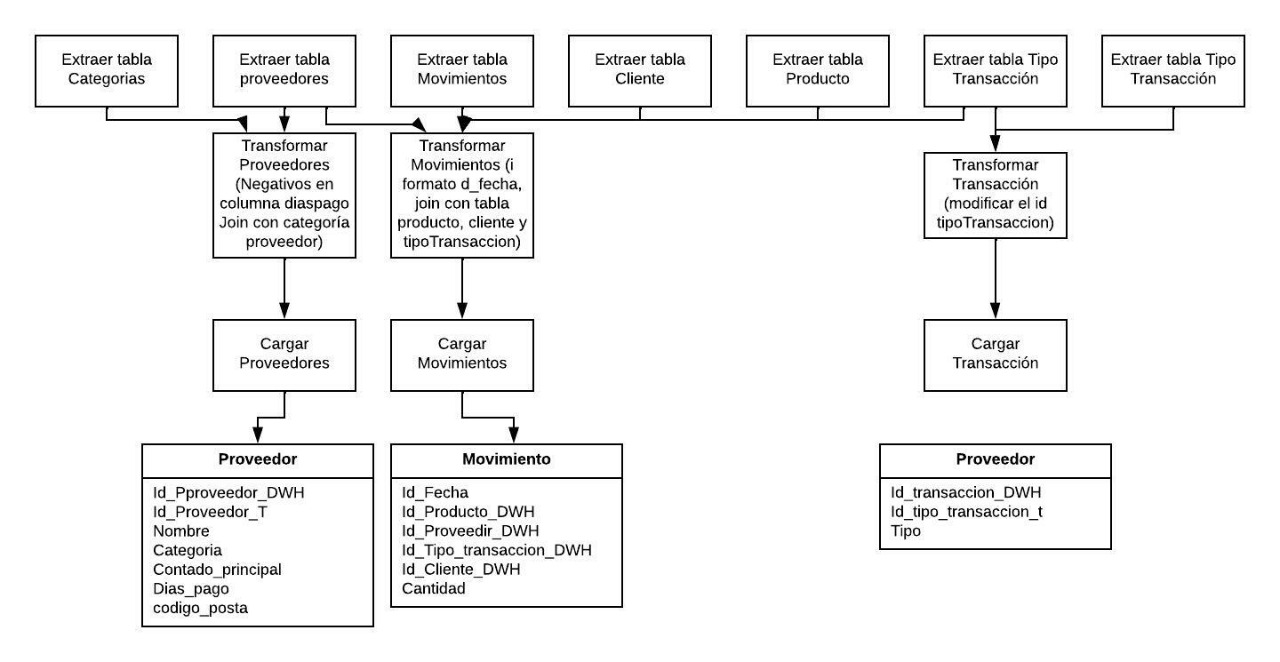